In [8]:
import os
import io
import numpy as np
from PIL import Image

# Optional imports:
try:
    import requests
except Exception:
    requests = None

try:
    from skimage.metrics import structural_similarity as ssim
except Exception:
    ssim = None

from sklearn.cluster import KMeans


# Image Path
INPUT_IMAGE_PATH_OR_URL = r"/content/Problem_Statement_2_Image.jpg"

OUTPUT_DIR = "outputs_quant"
K_VALUES = [2, 4, 6, 8, 10]
RANDOM_STATE = 42
MAX_ITER = 200
N_INIT = "auto"


def load_image_rgb(path_or_url):
    """Load image as RGB from local path or URL."""
    if path_or_url.startswith(("http://", "https://")):
        if requests is None:
            raise RuntimeError("requests not installed; cannot load from URL. Use a local path or install 'requests'.")
        resp = requests.get(path_or_url, timeout=30)
        resp.raise_for_status()
        img = Image.open(io.BytesIO(resp.content)).convert("RGB")
    else:
        img = Image.open(path_or_url).convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    return img, arr


def kmeans_quantize(arr_rgb, K, random_state=RANDOM_STATE, max_iter=MAX_ITER, n_init=N_INIT):
    """Run k-means in RGB space and return quantized image, labels, and centroids."""
    h, w, c = arr_rgb.shape
    pixels = arr_rgb.reshape(-1, c).astype(np.float32)

    km = KMeans(n_clusters=K, random_state=random_state, max_iter=max_iter, n_init=n_init)
    labels = km.fit_predict(pixels)
    centroids = km.cluster_centers_.astype(np.float32)

    quant_pixels = centroids[labels]
    quant_arr = np.clip(quant_pixels, 0, 255).astype(np.uint8).reshape(h, w, c)
    return quant_arr, labels.reshape(h, w), centroids


def compute_metrics(orig, quant):
    """Return MSE, PSNR, and SSIM (if available)."""
    diff = orig.astype(np.float32) - quant.astype(np.float32)
    mse = float(np.mean(diff ** 2))
    psnr = 10.0 * np.log10((255.0 ** 2) / (mse + 1e-12))

    ssim_val = None
    if ssim is not None:
        # Compute SSIM on luminance for perceptual relevance (BT.601)
        Y_orig = 0.299 * orig[..., 0] + 0.587 * orig[..., 1] + 0.114 * orig[..., 2]
        Y_quant = 0.299 * quant[..., 0] + 0.587 * quant[..., 1] + 0.114 * quant[..., 2]
        ssim_val = float(ssim(Y_orig.astype(np.float32), Y_quant.astype(np.float32), data_range=255.0))
    return mse, psnr, ssim_val


def save_image(arr, path):
    Image.fromarray(arr).save(path)


def run_quantization(input_path_or_url, output_dir, Ks):
    os.makedirs(output_dir, exist_ok=True)
    _, arr = load_image_rgb(input_path_or_url)
    print(f"Image loaded: {input_path_or_url} | Shape: {arr.shape}")

    results = []
    for K in Ks:
        quant_arr, labels, centroids = kmeans_quantize(arr, K)
        mse, psnr, ssim_val = compute_metrics(arr, quant_arr)

        out_path = os.path.join(output_dir, f"quantized_K{K}.png")
        save_image(quant_arr, out_path)

        print_str = f"K={K:>2} | MSE={mse:.2f} | PSNR={psnr:.2f} dB"
        if ssim_val is not None:
            print_str += f" | SSIM={ssim_val:.4f}"
        print_str += f" | saved -> {out_path}"
        print(print_str)

        results.append({
            "K": K,
            "MSE": mse,
            "PSNR_dB": psnr,
            "SSIM": ssim_val,
            "output_path": out_path,
            "palette_RGB": centroids.astype(np.uint8)
        })
    return results


if __name__ == "__main__":
    results = run_quantization(INPUT_IMAGE_PATH_OR_URL, OUTPUT_DIR, K_VALUES)
    # print palettes for each K
    for r in results:
        print(f"\nPalette (K={r['K']}, RGB centroids):")
        print(r["palette_RGB"])




Image loaded: /content/Problem_Statement_2_Image.jpg | Shape: (512, 512, 3)
K= 2 | MSE=1616.99 | PSNR=16.04 dB | SSIM=0.6004 | saved -> outputs_quant/quantized_K2.png
K= 4 | MSE=664.99 | PSNR=19.90 dB | SSIM=0.6982 | saved -> outputs_quant/quantized_K4.png
K= 6 | MSE=439.92 | PSNR=21.70 dB | SSIM=0.7372 | saved -> outputs_quant/quantized_K6.png
K= 8 | MSE=331.94 | PSNR=22.92 dB | SSIM=0.8048 | saved -> outputs_quant/quantized_K8.png
K=10 | MSE=282.35 | PSNR=23.62 dB | SSIM=0.8367 | saved -> outputs_quant/quantized_K10.png

Palette (K=2, RGB centroids):
[[159 172 169]
 [122  96  72]]

Palette (K=4, RGB centroids):
[[158 184 198]
 [133 138 114]
 [ 73  78  60]
 [225 101  67]]

Palette (K=6, RGB centroids):
[[140 187 223]
 [110 120 103]
 [ 66  70  53]
 [231  84  61]
 [178 156  94]
 [172 172 158]]

Palette (K=8, RGB centroids):
[[183 180 165]
 [126 144 143]
 [ 83  91  72]
 [231  84  61]
 [185 158  97]
 [118 121  93]
 [ 52  54  39]
 [141 189 225]]

Palette (K=10, RGB centroids):
[[185 194 20

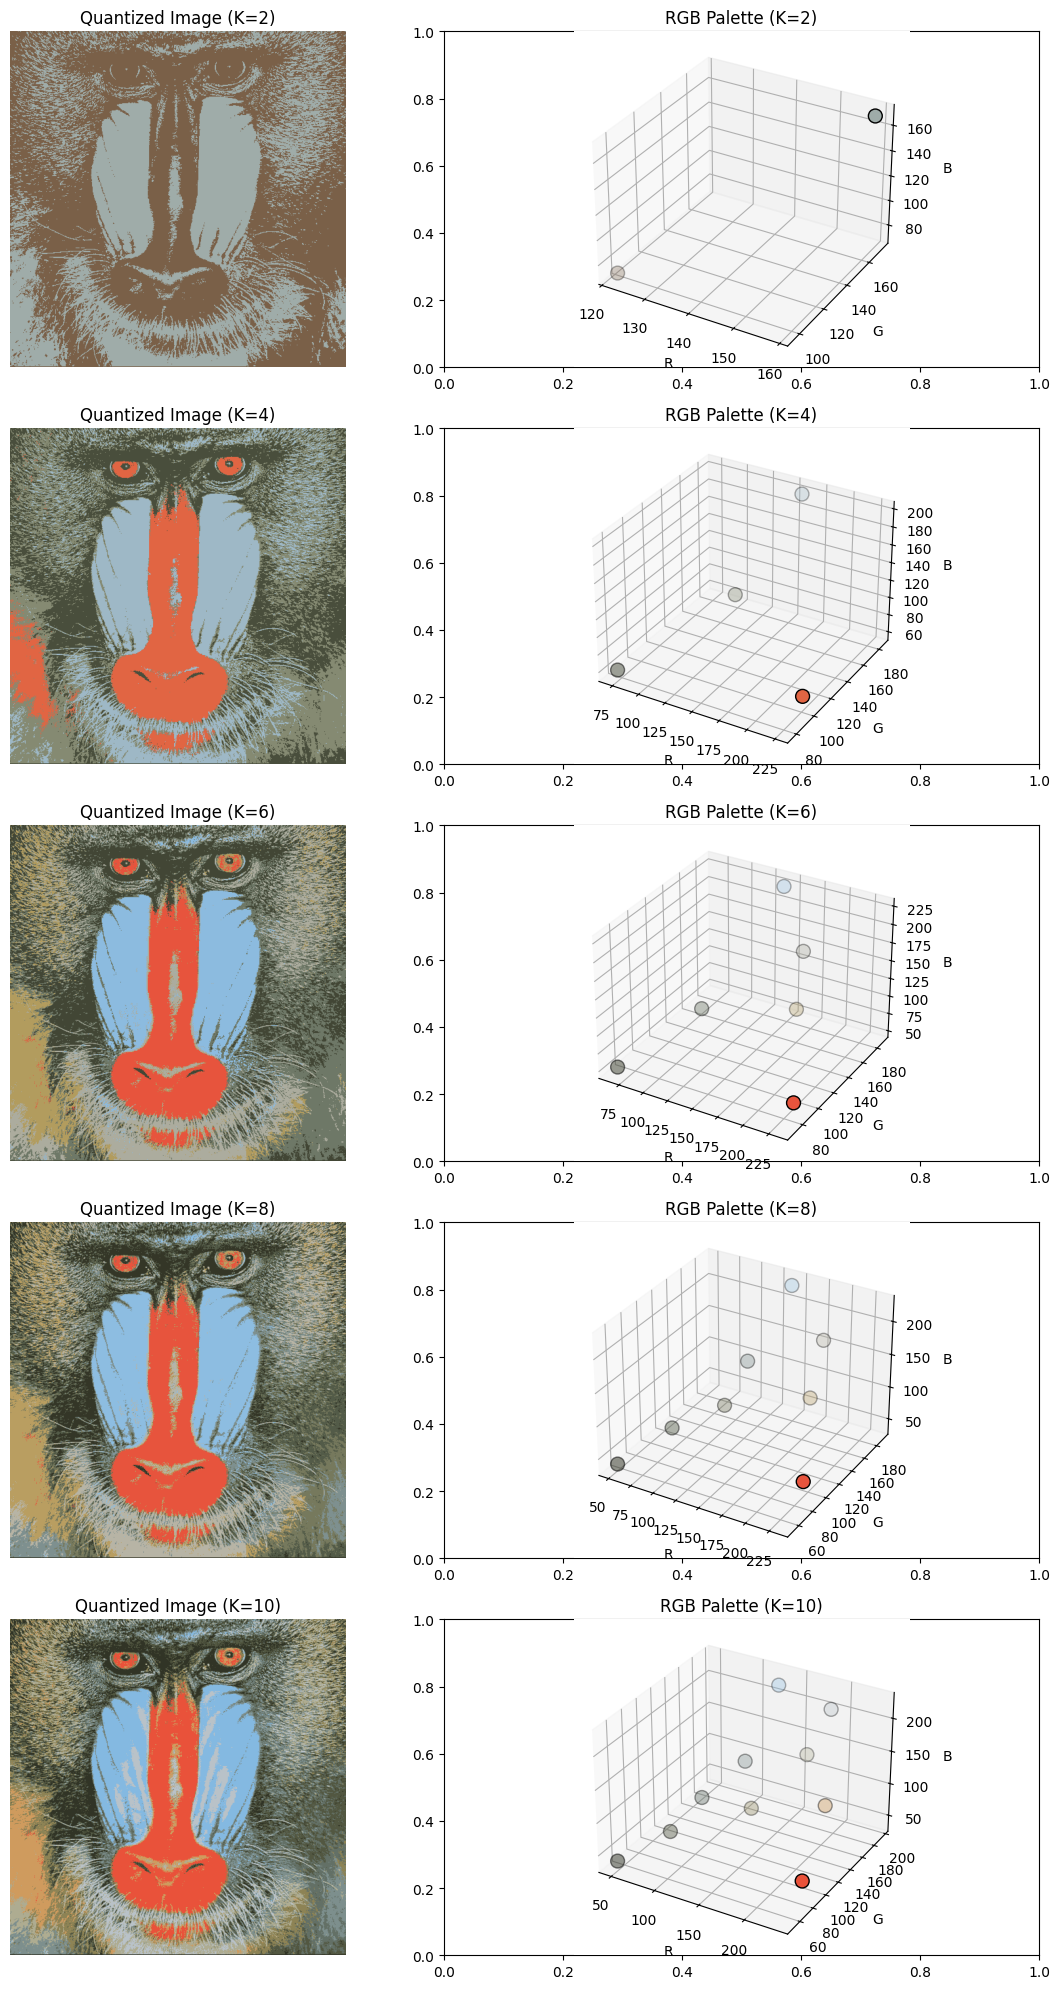

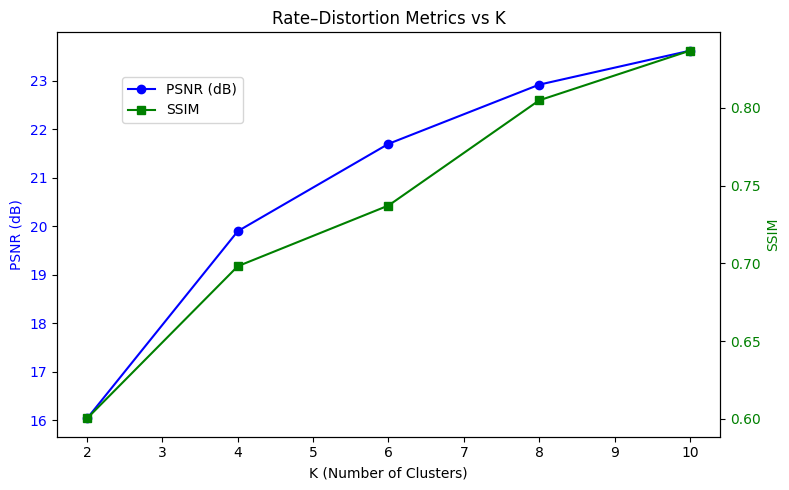

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# Metrics from the above results
K_values = [2, 4, 6, 8, 10]
MSE_values = [1616.99, 664.99, 439.92, 331.94, 282.35]
PSNR_values = [16.04, 19.90, 21.70, 22.92, 23.62]
SSIM_values = [0.6004, 0.6982, 0.7372, 0.8048, 0.8367]

# Centroids for each K from the above results
centroids_dict = {
    2: np.array([[159, 172, 169], [122, 96, 72]]),
    4: np.array([[158, 184, 198], [133, 138, 114], [73, 78, 60], [225, 101, 67]]),
    6: np.array([[140, 187, 223], [110, 120, 103], [66, 70, 53],
                 [231, 84, 61], [178, 156, 94], [172, 172, 158]]),
    8: np.array([[183, 180, 165], [126, 144, 143], [83, 91, 72], [231, 84, 61],
                 [185, 158, 97], [118, 121, 93], [52, 54, 39], [141, 189, 225]]),
    10: np.array([[185, 194, 200], [125, 143, 141], [141, 131, 85], [207, 155, 94],
                  [174, 172, 145], [99, 112, 102], [49, 52, 38], [132, 185, 225],
                  [82, 87, 65], [233, 82, 58]])
}

#  Paths to quantized images
image_paths = {
    2: "outputs_quant/quantized_K2.png",
    4: "outputs_quant/quantized_K4.png",
    6: "outputs_quant/quantized_K6.png",
    8: "outputs_quant/quantized_K8.png",
    10: "outputs_quant/quantized_K10.png"
}

#  Visualization: Images + RGB Palettes
fig, axes = plt.subplots(len(K_values), 2, figsize=(12, 20))

for idx, K in enumerate(K_values):
    # Load quantized image
    img = Image.open(image_paths[K])
    axes[idx, 0].imshow(img)
    axes[idx, 0].axis("off")
    axes[idx, 0].set_title(f"Quantized Image (K={K})")

    # Plot RGB centroids in 3D
    ax3d = fig.add_subplot(len(K_values), 2, 2*idx+2, projection='3d')
    centroids = centroids_dict[K]
    ax3d.scatter(centroids[:,0], centroids[:,1], centroids[:,2],
                 c=centroids/255.0, s=100, edgecolors='k')
    ax3d.set_xlabel("R")
    ax3d.set_ylabel("G")
    ax3d.set_zlabel("B")
    ax3d.set_title(f"RGB Palette (K={K})")

plt.tight_layout()
plt.show()

#  Visualization: PSNR and SSIM vs K
fig2, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(K_values, PSNR_values, 'o-b', label='PSNR (dB)')
ax1.set_xlabel("K (Number of Clusters)")
ax1.set_ylabel("PSNR (dB)", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Rate–Distortion Metrics vs K")

# Twin axis for SSIM
ax2 = ax1.twinx()
ax2.plot(K_values, SSIM_values, 's-g', label='SSIM')
ax2.set_ylabel("SSIM", color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig2.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
plt.tight_layout()
plt.show()
